# **Project 5: Exploring StackExchange Data**
a homework assignment for CIS 545: Big Data Analytics

In the first section, we will familiarize ourselves with SQL (specifically **pandassql** and explore the Stack Exchange dataset. We will also finish out the section with some text analysis.

The second section will focus on graph data and give you a small preview of Spark using the Yelp dataset. This homework is designed to introduce you to Spark's required workflow before you fully unlease its power next homework and deploy it on an AWS cluster. 

# Section 0: Homework Initialization

## Part -2: Install the Proper Version of Pandas

Run the following cell to install the proper version of pandas. After running this cell, restart your runtime (Runtime > Restart runtime) and then run all the remaining set up cells. 

In [ ]:
!pip3 install pandas==1.0.5

In [ ]:
# make sure that this cell prints True! Otherwise you may have forgotten to
# restart your runtime after running the cell above
import pandas as pd
print(pd.__version__ == '1.0.5')

True


## Part -1: Enter your PennID

In [ ]:
STUDENT_ID =  65606672

## Part 0: Libraries and Set Up Jargon (The usual wall of imports)

In [ ]:
#! sudo apt install openjdk-8-jdk
#! sudo update-alternatives --config java

In [ ]:
!pip3 install penngrader

from penngrader.grader import *

In [ ]:
grader = PennGrader(homework_id = 'CIS545_Fall_2020_HW2', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 65606672

Make sure this correct or we will not be able to store your grade


In [ ]:
### Install required packages
%%capture
!pip3 install lxml
!pip install pandasql
!pip install googledrivedownloader

In [ ]:
import numpy as np
import matplotlib

import gc
import time
import warnings

import json # JSON parsing
from lxml import etree # HTML parsing
import time # Time conversions
from lxml import etree # XML Parser
import pandasql as ps #SQL on Pandas Dataframe

import nltk
nltk.download('punkt')

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!




# Section 1: Exploring the Stack Exchange Dataset


<img src = "https://cdn.sstatic.net/Sites/stackoverflow/company/img/logos/se/se-logo.png?v=dd7153fcc7fa" width= "600" align ="center"/>

To survive as a student at Penn , you've certainly used Stack Exchange or Stack Overflow, as a source for all your technical queries. Stack Exchange looks a lot like a social network, it has the following pieces of information to tie it all together:


*   Users: All stack exchange users including admins etc.

*   Posts: All the questions as well as the answers that users post

*   Comments: As the name suggests, these are comments on posts

*   Votes: Up/Downvotes 


For this homework we'll be parsing this data (dumped in XML) into dataframes and relations, and then exploring how to query and assemble the tables into results with Pandas and  PandaSQL.

## Part 1: Loading our datasets [12 points total]

Before we get into the data, we first need to load our datasets. We will actually only be using the Users and Posts datasets for our queries, but we want you to write a generalized xml parsing function that would be able to convert any of the xml files into a dataframe.

### 1.0 Importing Data

Below is the code to import the xml files from our shared Google Drive. The data is relatively small, so this shouldn't take too long. We will only import the Users and Posts xmls for now, but the other datasets are there in case you want to take a look :)

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1T-SGFULQIkpg6LN5XLhBfiXhcAWNgCLe',
                                    dest_path='/content/Users.xml')

gdd.download_file_from_google_drive(file_id='1etuY-EjzgEfMdPCSd7NblNz0qJJpAH3b',
                                    dest_path='/content/Posts.xml')

### 1.1 Load Dataset Function

Now that we finally have all our packages imported and datasets initalized, it's time to finally write some code! Your first task is to write the function **xml_to_df(file_path)** that will parse the specified file into a dataframe. This function should be generalized, in the sense that it can accept any of the xml files that we loaded and return a dataframe. We highly recommend looking over the [xml documentation](https://docs.python.org/2/library/xml.etree.elementtree.html) in order to accomplish this task.

**TODO:** Once you have written **xml_to_df(file_path)**, create a **posts_df** and **users_df** with the parsed XML files (`/content/Users.xml` and `/content/Posts.xml`)

Tip: try figuring out the steps with one of the two XML files first! 

In [ ]:
#Solution

def xml_to_df(file_path):
  #Getting tree and root
  tree = etree.parse(file_path)
  root = tree.getroot()

  #Creating a series list that we'll append to
  series_list = []

  for i in np.arange(len(root)):
    series_list.append(pd.Series(root[i].attrib))

  return pd.DataFrame(series_list)

In [ ]:
#Creating the posts_df
posts_df = xml_to_df('Posts.xml')

In [ ]:
# [CIS 545 PennGrader Cell] - 5 points
grader.grade(test_case_id = 'test_xml_to_posts_df', answer = posts_df[:75])

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
 #Creating the users_df
users_df = xml_to_df('Users.xml')

In [ ]:
grader.grade(test_case_id = 'test_xml_to_users_df', answer = users_df[:75])

### 1.2 Clean Dataset

Next, we are going to want to clean up our dataframes, namely 1) removing null values,  2) changing datatypes, and 3) dropping columns

Originally, we were going to have you identify the datatypes with this [image](https://i.stack.imgur.com/AyIkW.png) on your own, but I (the TA writing this section) found this part really tedious and rage-inducing so we have defined the specific columns to convert below. All you need to do is write the function :)

**TODO**: 1) replace all null values in both datasets **in-place**. 2) define a function **dtype_converter(df, int_columns)** that takes in a dateframe and a list specifying which columns should be integers. Then, use this function on both posts_df and users_df using the lists defined below. (Note: we don't need to convert any columns to strings since they're already objects, and we're ignoring datetime)

In [ ]:
##TODO replace NA values here
posts_df.fillna(0, inplace=True)
users_df.fillna(0, inplace=True)

In [ ]:
#columns that need to be integers
int_posts_cols = ["Id", "PostTypeId", "AcceptedAnswerId", "ParentId", "Score", 
                  "ViewCount", "OwnerUserId", "LastEditorUserId", "AnswerCount",
                  "CommentCount", "FavoriteCount"]
int_users_cols = ["Id", "Reputation", "Views", "UpVotes", "DownVotes", "AccountId"]

In [ ]:
#Creating the dtype_convertert
def dtype_converter(df, int_columns):
  df[int_columns] = df[int_columns].astype(int)

In [ ]:
#Applying the function
dtype_converter(posts_df, int_posts_cols)
dtype_converter(users_df, int_users_cols)

In [ ]:
grader.grade(test_case_id = 'test_posts_dtypes', answer = posts_df[:75])

In [ ]:
grader.grade(test_case_id = 'test_users_dtypes', answer = users_df[:75])

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Part 1.5 Your Sandbox 

Instead of throwing you straight into the deep end, we wanted to give you a chance to take some time and explore the data on your own. **This section is not graded**, so for the speedrunners out there feel free to just jump in, but we wanted to at least give you a small space to utilize your basic EDA toolkit to familiarize yourself with all the info you just downloaded.

Some suggestions to get you started:
- `df.head()`
- `df.info()`
- `df.describe()`

Also, definitely take a look at [this readme](https://ia800107.us.archive.org/27/items/stackexchange/readme.txt) that provides a good overview of all the datasets (ignore the ones that you did not ask you to convert)


In [ ]:
# your EDA here! feel free to add more cells

Looking at the posts DF

In [ ]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43650 entries, 0 to 43649
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Id                     43650 non-null  int64 
 1   PostTypeId             43650 non-null  int64 
 2   CreationDate           43650 non-null  object
 3   Score                  43650 non-null  int64 
 4   ViewCount              43650 non-null  int64 
 5   Body                   43650 non-null  object
 6   OwnerUserId            43650 non-null  int64 
 7   LastActivityDate       43650 non-null  object
 8   Title                  43650 non-null  object
 9   Tags                   43650 non-null  object
 10  AnswerCount            43650 non-null  int64 
 11  CommentCount           43650 non-null  int64 
 12  FavoriteCount          43650 non-null  int64 
 13  ClosedDate             43650 non-null  object
 14  AcceptedAnswerId       43650 non-null  int64 
 15  LastEditorUserId   

In [ ]:
posts_df.describe()

,Id,PostTypeId,Score,ViewCount,OwnerUserId,AnswerCount,CommentCount,FavoriteCount,AcceptedAnswerId,LastEditorUserId,ParentId
count,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000
mean,33696.982818,1.558351,2.004536,595.410676,39586.090699,0.519267,1.031226,0.337411,4857.107652,11776.039954,15623.294593
std,18077.230742,0.590963,5.047551,4145.858473,25379.183117,0.931431,1.843895,2.472144,13304.044427,21450.345970,19872.376400
min,5.000000,1.000000,-6.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,17677.500000,1.000000,0.000000,0.000000,15850.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33486.500000,2.000000,1.000000,0.000000,40827.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1002.000000
75%,49081.750000,2.000000,2.000000,97.000000,61756.000000,1.000000,1.000000,0.000000,0.000000,15588.500000,29984.000000
max,64049.000000,7.000000,212.000000,202040.000000,86213.000000,35.000000,24.000000,186.000000,64045.000000,86202.000000,64034.000000


In [ ]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71647 entries, 0 to 71646
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Id               71647 non-null  int64 
 1   Reputation       71647 non-null  int64 
 2   CreationDate     71647 non-null  object
 3   DisplayName      71647 non-null  object
 4   LastAccessDate   71647 non-null  object
 5   WebsiteUrl       71647 non-null  object
 6   Location         71647 non-null  object
 7   AboutMe          71647 non-null  object
 8   Views            71647 non-null  int64 
 9   UpVotes          71647 non-null  int64 
 10  DownVotes        71647 non-null  int64 
 11  AccountId        71647 non-null  int64 
 12  ProfileImageUrl  71647 non-null  object
dtypes: int64(6), object(7)
memory usage: 7.1+ MB


In [ ]:
users_df.describe()

,Id,Reputation,Views,UpVotes,DownVotes,AccountId
count,71647.000000,71647.000000,71647.000000,71647.000000,71647.000000,7.164700e+04
mean,45689.791855,49.106229,1.260709,1.296272,0.122392,7.285739e+06
std,24023.886660,168.814179,18.642392,26.714577,10.176406,4.942315e+06
min,-1.000000,1.000000,0.000000,0.000000,0.000000,-1.000000e+00
25%,25971.500000,1.000000,0.000000,0.000000,0.000000,2.930484e+06
50%,46153.000000,1.000000,0.000000,0.000000,0.000000,6.843439e+06
75%,66211.500000,101.000000,0.000000,0.000000,0.000000,1.128824e+07
max,86215.000000,20524.000000,2239.000000,4639.000000,2162.000000,1.721386e+07


## Part 2: Exploring the data with Pandas and PandasSQL [20 points total]

Now that you are familiar (or still unfamiliar) with the dataset, we will now introduce you to SQL, or more specifically **pandasql**: a package create to allow users to query pandas DataFrames with SQL statements.

The typical flow to use pandasql (shortened to **ps**) is as follows:
1. write a SQL query in the form of a string (Tip: use triple quotes """x""" to write multi-line strings)
2. run the query using **ps.sqldf(your_query, locals())**

Pandasql is convenient in that it allows you to reference the dataframes that are currently defined in your notebook, so you will be able to fully utilize the `posts_df` and `users_df` that you have created above!

Given that it is a brand new language, we wanted to give you a chance to directly compare the similarities/differences of the pandas that you already know and the SQL you are about to learn. Thus, for each query, we ask that you to **look into the question twice: once with pandas and once with pandasql**. 

Each answer will thus require both a `pd_` and `sql_` prefixed-dataframe that you will submit seperately to the autograder. **We will be reviewing your code to make sure you wrote the code in the corresponding languages.**

 [Here](https://community.alteryx.com/t5/Data-Science/pandasql-Make-python-speak-SQL/ba-p/138435) is a good resource to review pandasql. 



### 2.1 Spliting Up `posts_df`

`posts_df` actually contains both posted questions and the answers. The provided readme details the distinguishing factors as follows:

        - PostTypeId
            - 1: Question
            - 2: Answer
        - ParentID (only present if PostTypeId is 2)
        - AcceptedAnswerId (only present if PostTypeId is 1)

**TODO:** Using pandas/pandasql, split `posts_df` into a `pd/sql_questions_df` and `pd/sql_answers_df` based on these values of `PostTypeId`. 



In [ ]:
pd_questions_df = posts_df[posts_df["PostTypeId"] == 1]
pd_answers_df = posts_df[posts_df["PostTypeId"] == 2]

In [ ]:
grader.grade(test_case_id = 'test_pd_questions_df', answer = pd_questions_df["PostTypeId"].values)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
grader.grade(test_case_id = 'test_pd_answers_df', answer = pd_answers_df["PostTypeId"].values)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
questions_query = "select * from posts_df where PostTypeId = 1"
answers_query = "select * from posts_df where PostTypeId = 2"

sql_questions_df = ps.sqldf(questions_query, locals())
sql_answers_df = ps.sqldf(answers_query, locals())

In [ ]:
grader.grade(test_case_id = 'test_qa_query', answer = (questions_query,answers_query))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
#using just our sql dataframe moving forward
questions_df = sql_questions_df
answers_df = sql_answers_df

### 2.2 What are the most popular questions?

**TODO**: Use `questions_df` to find the 10 most popular questions by `ViewCount`.

Store the results in `pd/sql_popular_df` which be have the following format:

>Id | Title | ViewCount
>--- | --- | ---

Hint: for your SQL query, you will need to know `ORDER BY`, `LIMIT`

In [ ]:
#Creating the popular DF
pd_popular_df = questions_df[["Id", "Title", "ViewCount"]].sort_values(by=["ViewCount"], ascending=False).head(10)

In [ ]:
grader.grade(test_case_id = 'test_pd_popular_df', answer = pd_popular_df)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
#Generating the SQL DataFrame
popular_query = "select Id, Title, ViewCount from questions_df order by ViewCount desc limit 10"
sql_popular_df = ps.sqldf(popular_query, locals())

In [ ]:
grader.grade(test_case_id = 'test_popular_query', answer = popular_query)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
grader.grade(test_case_id = 'test_sql_popular_df', answer = sql_popular_df)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3 Who are the most helpful users?

**TODO:**  Use `answers_df` to find the names of the top 10 users who answer the most questions on stack exchange. This should be based on the count of unique answers made by the user.

Your answer, stored in `pd/sql_talkative_df` will have the following format:

>UserId | DisplayName | ResponseCount
>--- | --- | ---


Note: both `users_df` and `answers_df` have an `Id` column, but store entirely different values in them! 

SQL Hint: The tools that you will need include, but are not limited to`AS`, `JOIN`, `GROUP BY`, `ORDER BY` and `LIMIT`

In [ ]:
#Generating the response count by using groupby and count() as each row is an answer
pd_talkative_df = answers_df.groupby(by=["OwnerUserId"]).count().reset_index().iloc[:,:2]

#Renaming the approriate column names
pd_talkative_df.columns = ["UserId", "ResponseCount"]

#Merging with User_df to obtain display names - inner join so there are no NaNs
pd_talkative_df = pd_talkative_df.merge(users_df, right_on="Id", left_on="UserId")[["UserId", "ResponseCount", "DisplayName"]].sort_values(by=["ResponseCount"], ascending=False).head(10)

In [ ]:
grader.grade(test_case_id = 'test_pd_talkative_df', answer = pd_talkative_df)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
#Generating the SQL DataFrame
talkative_query = ''' SELECT answers_df.OwnerUserId AS UserId, users_df.DisplayName, COUNT(answers_df.OwnerUserId) AS ResponseCount
                      FROM answers_df
                      JOIN users_df
                      ON answers_df.OwnerUserId = users_df.Id
                      GROUP BY UserId
                      ORDER BY ResponseCount DESC
                      LIMIT 10
                      '''
sql_talkative_df = ps.sqldf(talkative_query, locals())

In [ ]:
grader.grade(test_case_id = 'test_talkative_query', answer = talkative_query)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
grader.grade(test_case_id = 'test_sql_talkative_df', answer = sql_talkative_df)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.4 Who are the most helpful-in-a-different-kind-of-way users?

**TODO**: find the users that ask a lot of questions, but have never posted an answer. To accomplish this, you are going to want to find all the users in `questions_df` that don't appear in `answers_df`. Sort by `QuestionsCount` descending and store only the top 5 results.

The query will require you to write a [nested SQL query](https://learnsql.com/blog/sql-nested-select/). That is, there will be at least one select statement inside of a select statement. This means that you **should NOT** write two seperate SQL commands and call ps.sqldf() twice. 

Though it would be helpful, **you do NOT have to implement this in pandas**. Your answer, stored in `askers_df` will have the following format:

>UserId | DisplayName | QuestionsCount
>--- | --- | ---


SQL Hint: You can use `NOT IN` or `LEFT JOIN`.

In [ ]:
#Generating the SQL DataFrame
askers_query = ''' SELECT questions_df.OwnerUserId AS UserId, users_df.DisplayName AS DisplayName, COUNT(questions_df.OwnerUserId) AS QuestionsCount
                      FROM questions_df
                      JOIN users_df
                      ON UserId = users_df.Id
                      WHERE UserId NOT IN (SELECT answers_df.OwnerUserID
                        FROM answers_df)
                      GROUP BY UserId
                      ORDER BY QuestionsCount DESC
                      LIMIT 5;
                      '''

askers_df = ps.sqldf(askers_query, locals())

In [ ]:
grader.grade(test_case_id = 'test_askers_query', answer = askers_query)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
grader.grade(test_case_id = 'test_askers_df', answer = askers_df)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.5 So which is better, SQL or Pandas?

Now that you have a taste for SQL, let's try to use our new skill to query stack exchange in this notebook and put this debate to rest.

**TODO**: Find all of the answers to a post that asks about Pandas vs. SQL. Here are some clues that will come in handy:
1. This post contains the words "pandas" and "sql"
2. This post has the most viewcount out of all the posts with both of those words
3. The answers to this post have the column `ParentId` equal to the post's `Id`

Again, no need to do this in pandas, but your answer, stored in `versus_df` will have the following format:

> QuestionId | Question | QuestionBody | AnswerId | AnswerBody 
>--- | --- | --- | --- | ---

SQL Hint: take a look at the `LIKE` function


In [ ]:
#Generating the SQL DataFrame
versus_query = ''' SELECT questions_df.Id AS QuestionID, questions_df.Title AS Question, questions_df.Body AS QuestionBody, MAX(questions_df.ViewCount) AS Views,
                   answers_df.ParentId AS AnswerID, answers_df.Body AS AnswerBody
                   FROM questions_df
                   WHERE Question LIKE '%Pandas%' AND Question LIKE '%SQL%'
                   JOIN answers_df ON QuestionID = AnswerID
                '''

versus_df = ps.sqldf(versus_query, locals())
versus_df

PandaSQLException: ignored

In [ ]:
#Generating the SQL DataFrame
versus_query = ''' SELECT answers_df.ParentId AS QuestionID, questions_df.Title AS Question, questions_df.Body AS QuestionBody, answers_df.Id AS AnswerID, answers_df.Body AS AnswerBody, questions_df.ViewCount AS Views
                   FROM answers_df
                   JOIN questions_df ON answers_df.ParentId = questions_df.Id
                   WHERE Question LIKE '%Pandas%' AND Question LIKE '%SQL%'
                               
                '''

versus_df = ps.sqldf(versus_query, locals())
versus_df

In [ ]:
questions_df[questions_df["ViewCount"] == questions_df[(questions_df["Title"].str.contains("SQL")) & (questions_df["Title"].str.contains("Pandas"))]["ViewCount"].max()]

In [ ]:
answers_df[answers_df["ParentId"] == 34357]

In [ ]:
versus_query = #TODO
versus_df = #TODO

We highly recommend that you read the responses! They are actually all pretty accurate and go into the pros/cons that you probably encountered while working through the problem set. Use `pd.set_option('display.max_colwidth', -1)` to view the full columns and when you're done set the colwidth back to a value like `20` so that you don't have giant dataframes in the next steps.

(You could also try to find the same question via Google Search)

In [ ]:
#pd.set_option('display.max_colwidth', -1)
#versus_df

In [ ]:
grader.grade(test_case_id = 'test_versus_query', answer = versus_query)

In [ ]:
grader.grade(test_case_id = 'test_versus_df', answer = versus_df)

## Part 3: Working with Text Data [22 points]

Shifting gears, let's now try to do some text-based analysis. Our Stack Exchange data has plenty of text that we can play with, from the user descriptions to the posts themselves. Text data is complex, but can also be used to generate extremely interpretable results, making it valuable and interesting. 

Throughout this section, we will attempt to answer the following:

### What types of questions should I ask to get a higher reputation on Stack Exchange? 

Users on stack exchange are valued based on their reputation, which depends on the quality of your posts. Each post receives a score, where **score = number of upvotes - number of downvotes**. This value is already present in your posts_df. 

Both questions and answers get scores, but let's just focus on what types of questions we should/shouldn't ask in order to get a higher score and thus higher reputation.


### 3.1 Getting Highest and Lowest Scored Posts
**TODO:** First, let's get questions with the negative scores from `questions_df` and then get the **same number** of questions with highest scores. Convert the **Body** column of the highest/lowest scorers into two lists: **highest_content** and **lowest_content**. Be sure to sort when needed!

Feel free to use either **pandas** or **pandasql** to accomplish this :)

In [ ]:
highest_content = questions_df.sort_values(by=["Score"], ascending=False)[:len(questions_df[questions_df["Score"] < 0])]["Body"].tolist()
lowest_content = questions_df[questions_df["Score"] < 0].sort_values(by=["Score"])["Body"].tolist()

In [ ]:
grader.grade(test_case_id = 'test_lowest_content', answer = lowest_content)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
grader.grade(test_case_id = 'test_highest_content', answer = highest_content)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.2 Cleaning our Text with Regex
Now that we have the content of our highest/lowest scored posts, we will now need to clean and tokenize them. 


First, before we do anything, let's just take a look at what we are working with


You probably noticed a couple of things:

1. html tags (\<p\>, \<a\>, etc.)
2. embedded latex (words surrounded $$)
3. newline characters(\n)

We are going to clean out all of these cases using **regex**, a staple text processing tool that matches strings based on a specified pattern. Creating these patterns is actually considered a form of art to some, as the syntax is very extensive. As a brief introduction here are some basic pattern components that you will need to know:
- "c": matches a "c" character in a string
- "c*?": matches 0 or more c characters
- "." matches any character
- ".*?c": matches any characters until you encounter "c"

Note: the "?" makes the astericks less greedy and severe when removing parts of the string. It's good practice to include it, but not always necessary.

**TODO:** Below, create a function **remove_bad_patterns(text)** that removes all of the 3 cases listed above from a given string, text. You will need to 
1. create patterns to handle each of the cases
2. use **re.sub(pattern, newstring)** to substitute all matches with the empty string, "". If you want to test your pattern, check out [this tool](https://regexr.com).

Note: "$" is considered a special character in regex, so you will need to escape it with "\\$" to specify you want to match the character.



In [ ]:
#Creaing the remove_bad_patterns function
import re

def remove_bad_patterns(text):
  #Handling HTML
  corrected_text = re.sub("<.*?>", "", text)
  #Handling Latex
  corrected_text = re.sub('\$.*?\$', "", corrected_text)
  #Handling newline characters
  corrected_text = re.sub('\n', "", corrected_text)
  return corrected_text

Now, apply this function to both **highest_content** and **lowest_content** to create **cleaned_highest_content** and **cleaned_lowest_content**, respectively, and let's take another look at the new and improved first entry:

In [ ]:
cleaned_highest_content = [remove_bad_patterns(entry) for entry in highest_content]
cleaned_lowest_content = [remove_bad_patterns(entry) for entry in lowest_content]

In [ ]:
grader.grade(test_case_id = 'test_cleaned_highest', answer = cleaned_highest_content)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
grader.grade(test_case_id = 'test_cleaned_lowest', answer = cleaned_lowest_content)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


A lot cleaner, right? Of course, it's not perfect but it'll do for our purposes in this homework. With that out of the way let us now...


###3.3 Tokenize the Text

Here, we are going to split up the content into a list of words. Here, we will use the **nltk** package, which contains an extensive set of tools to process text. Of course, like regex, this homework would be miles long if we really went into detail, so we are only going to utilize the following components:
- nltk.word_tokenize(): a function used to tokenize our text
- nltk.corpus.stopwords: a list of commonly used words such as "a","an","in" that are often ignored in text-related analysis


**TODO:** First, use **stopwords** to create a set of the most common english stopwords. Then, implement **tokenized_content(content)** that takes in a content string and 
1. tokenizes the text
2. lowercases the token
3. removes stop words (commonly used words such as "a","an", "in")]
4. keeps words with only alphabet characters (no punctuation)

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords = set(stopwords.words('english')) 

In [ ]:
words = nltk.word_tokenize(cleaned_highest_content[0])
words = [word.lower() for word in words if word.isalpha()]
words = [word for word in words if (word not in stopwords and word.isalpha())]


In [ ]:
def tokenize_content(content):
  words = nltk.word_tokenize(content)
  words = [word.lower() for word in words if word.isalpha()]
  words = [word for word in words if (word not in stopwords and word.isalpha())]
  return words

  """returns tokenized string

  :param content: text string
  :return: tokenized text/list of words
  """
  #TODO

Now, apply your tokenized_titles function to each piece of content in **cleaned_highest_content** and **cleaned_lowest content** and flatten both of the lists to create **highest_tokens** and **lowest_tokens**


In [ ]:
highest_tokens = [tokenize_content(entry) for entry in cleaned_highest_content]
lowest_tokens = [tokenize_content(entry) for entry in cleaned_lowest_content]

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
grader.grade(test_case_id = 'test_highest_tokens', answer = flatten(highest_tokens))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
grader.grade(test_case_id = 'test_lowest_tokens', answer = flatten(lowest_tokens))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.4 Most Frequent Words

Now, find the 20 most common words amongst the content of your highest and lowest questions.



Hint: https://docs.python.org/2/library/collections.html#counter-objects

In [ ]:
#Creating the lowest_counter and taking the 20 most common
lowest_counter = Counter()

for entry in lowest_tokens:
  for word in entry:
    lowest_counter[word] +=1

lowest_most_common = lowest_counter.most_common(20)

In [ ]:
#Creating the highest_counter and taking the 20 most common
highest_counter = Counter()

for entry in highest_tokens:
  for word in entry:
    highest_counter[word] +=1

highest_most_common = highest_counter.most_common(20)

In [ ]:
grader.grade(test_case_id = 'test_highest_most_common', answer = highest_most_common)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
grader.grade(test_case_id = 'test_lowest_most_common', answer = lowest_most_common)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


###3.5 Refining our Lists

Hmmm...both of these lists seem to overrepresent the common jargon of data science. Let's try to tease out words that distinguish the high from the low scoring posts. 

One approach would be to find words in one list that are not in the other. This, however, may be too naive, as even if a word is extremely common in our high list, if it appears only once in our low list, it would get removed from consideration.

Let's instead find the difference between the counts within our two lists. With this method, if a word is really common in one, but not the other, the count would only decrease slightly. Alternatively, if a word is common in both lists, it would effectively zero out.

**TODO:** Using the difference method, create a **distinct_highest_common** and **distinct_lowest_commonr**  that find the top 20 counts of words within each group of posts after using the difference method described above. Be careful on which list you are subtracting!


In [ ]:
#Creating the distinct_lowest_common set
distinct_lowest_common = (lowest_counter - highest_counter).most_common(20)

In [ ]:
#Creating the distinct_highest_common set
distinct_highest_common = (highest_counter - lowest_counter).most_common(20)

In [ ]:
grader.grade(test_case_id = 'test_distinct_highest_common', answer = distinct_highest_common)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
grader.grade(test_case_id = 'test_distinct_lowest_common', answer = distinct_lowest_common)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


The lists are much more different right? It seems as if low scoring posts tend to ask a lot about errors/code while higher posts are much more conceptual based.

So if you're a looking for a high reputation, don't ask people to debug your code!

### 3.6 Word Clouds

Before we move on from this dataset, let's do one final step and visualize our results with wordclouds.

**TODO**: Take a look at [this documentation](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) and create two word clouds for our two groups of distinct tokens.

Be sure to create these on the full list of distinct tokens, and not just the top 20. We will be going through your notebooks and manually grading your world clouds (worth 4 points). 


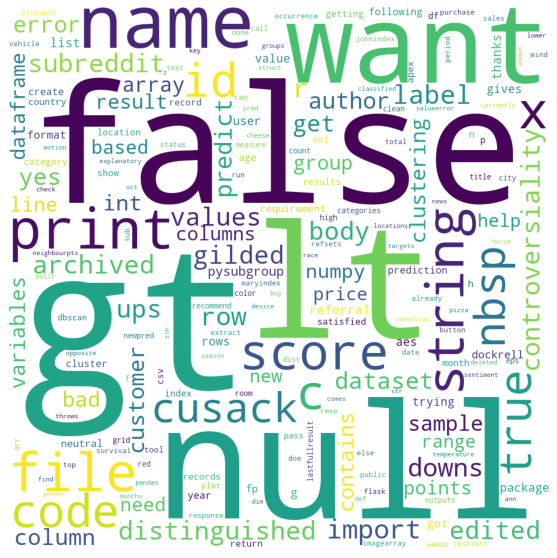

In [ ]:
#Generating the word clour for the lowest distinct set
wordcloud = WordCloud(width = 1000, height = 1000, background_color ='white', min_font_size = 5)

wordcloud.generate_from_frequencies(dict((lowest_counter - highest_counter))) 

# plot the WordCloud image                        
plt.figure(figsize = (10, 10)) 
plt.imshow(wordcloud) 
plt.axis("off") 

plt.show() 

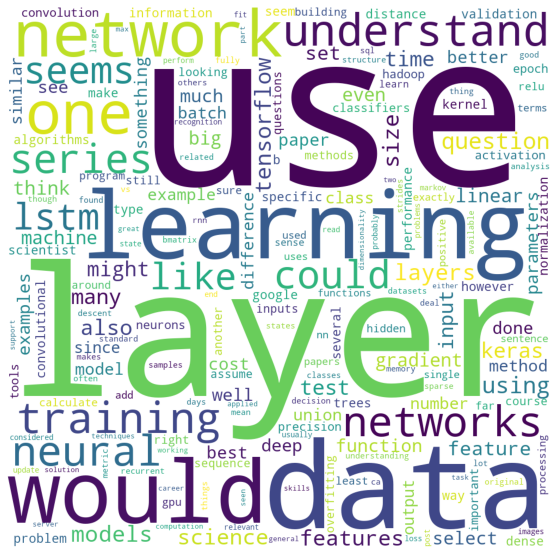

In [ ]:
#Generating the word clour for the highgest distinct set
wordcloud = WordCloud(width = 1000, height = 1000, background_color ='white', min_font_size = 5)

wordcloud.generate_from_frequencies(dict((highest_counter - lowest_counter))) 

# plot the WordCloud image                        
plt.figure(figsize = (10, 10)) 
plt.imshow(wordcloud) 
plt.axis("off") 

plt.show() 

#Section 2: Spark, Hierarchical Data and Graph Data on Yelp Reviews Dataset

## Getting Started with Apache Spark

Now that you've seen how to run SQL queries through pandas, we'll working with running SQL in Apache Spark! Apache Spark is a complex, cluster-based data processing system written in Scala used for big data processing. For the most part, Spark interfaces “smoothly” to Python.

While Spark dataframes try to emulate the same programming style as Pandas DataFrames, there are some differences in how you express things. Please refer to the Lecture Slides or the following resources to learn about these differences:

https://lab.getbase.com/pandarize-spark-dataframes/
https://ogirardot.wordpress.com/2015/07/31/from-pandas-to-apache-sparks-dataframe/ 

For this assignment, we are going to get familiar with Spark without worrying too much about sharding and distribution. This isn’t really using it to its strengths -- and in fact you might find Spark to be slow -- but it will get you comfortable with programming in Spark without worrying about distributed nodes, clusters, and spending real dollars on the cloud. For Homework 3, we’ll connect your Jupyter instance to Spark running on the cloud.

### Initializing a Connection to Spark

We'll open a connection to Spark as follows. From `SparkSession`, you can load data into Spark DataFrames as well as `RDD`s.

Run the following cells to setup this part of the notebook!

In [ ]:
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('Graphs-HW2').getOrCreate()


In [ ]:
%load_ext sparkmagic.magics

In [ ]:
import numpy as np
import pandas as pd
import matplotlib

#misc
import gc
import time
import warnings


#graph section
import networkx as nx
#import heapq  # for getting top n number of things from list,dict
import pandas as pd
import numpy as np

# JSON parsing
import json

# HTML parsing
from lxml import etree
import urllib

# SQLite RDBMS
import sqlite3

# Time conversions
import time

# Parallel processing
# import swifter

# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)


### Download data

The following code retrieves the Yelp dataset files from Google Drive.

In [ ]:
'''

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1XCANGSCd0pUNcXq18t2QDwCIpJxus8Dy',
                                    dest_path='/content/yelp_business_attributes.csv')

gdd.download_file_from_google_drive(file_id='11lwBibxX7PYGgOfHU25_dDDDsPX1Pt0Y',
                                    dest_path='/content/yelp_business.csv')

gdd.download_file_from_google_drive(file_id='1FU5Q-96erhTmk8SjC4XHUm94yWc6h3a0',
                                    dest_path='/content/yelp_checkin.csv')

gdd.download_file_from_google_drive(file_id='1UaaLrCKjqoQ7G3JT_VUw56pc-dnTwyrS', dest_path='/content/yelp_review2.csv')

gdd.download_file_from_google_drive(file_id='1JNFZeLlimxNSwcOb-oBxxbwJqdg22WgD',
                                    dest_path='/content/yelp_user.csv')

'''


"\n\nfrom google_drive_downloader import GoogleDriveDownloader as gdd\n\ngdd.download_file_from_google_drive(file_id='1XCANGSCd0pUNcXq18t2QDwCIpJxus8Dy',\n                                    dest_path='/content/yelp_business_attributes.csv')\n\ngdd.download_file_from_google_drive(file_id='11lwBibxX7PYGgOfHU25_dDDDsPX1Pt0Y',\n                                    dest_path='/content/yelp_business.csv')\n\ngdd.download_file_from_google_drive(file_id='1FU5Q-96erhTmk8SjC4XHUm94yWc6h3a0',\n                                    dest_path='/content/yelp_checkin.csv')\n\ngdd.download_file_from_google_drive(file_id='1UaaLrCKjqoQ7G3JT_VUw56pc-dnTwyrS', dest_path='/content/yelp_review2.csv')\n\ngdd.download_file_from_google_drive(file_id='1JNFZeLlimxNSwcOb-oBxxbwJqdg22WgD',\n                                    dest_path='/content/yelp_user.csv')\n\n"

In [ ]:
!wget https://penn-cis545-files.s3.amazonaws.com/yelp_business_attributes.csv -P /content
!wget https://penn-cis545-files.s3.amazonaws.com/yelp_business.csv -P /content
!wget https://penn-cis545-files.s3.amazonaws.com/yelp_checkin.csv -P /content
!wget https://penn-cis545-files.s3.amazonaws.com/yelp_review2.csv -P /content
!wget https://penn-cis545-files.s3.amazonaws.com/yelp_user.csv -P /content

--2020-10-13 18:00:10--  https://penn-cis545-files.s3.amazonaws.com/yelp_business_attributes.csv
Resolving penn-cis545-files.s3.amazonaws.com (penn-cis545-files.s3.amazonaws.com)... 52.217.70.92
Connecting to penn-cis545-files.s3.amazonaws.com (penn-cis545-files.s3.amazonaws.com)|52.217.70.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41377121 (39M) [text/csv]
Saving to: ‘/content/yelp_business_attributes.csv’

yelp_business_attri 100%[===================>]  39.46M   104MB/s    in 0.4s    

2020-10-13 18:00:10 (104 MB/s) - ‘/content/yelp_business_attributes.csv’ saved [41377121/41377121]

--2020-10-13 18:00:10--  https://penn-cis545-files.s3.amazonaws.com/yelp_business.csv
Resolving penn-cis545-files.s3.amazonaws.com (penn-cis545-files.s3.amazonaws.com)... 52.217.70.92
Connecting to penn-cis545-files.s3.amazonaws.com (penn-cis545-files.s3.amazonaws.com)|52.217.70.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31760674 (30M) [

## Part 4: Working with Spark [21 points total]



### 4.1 Load Our Datasets


In this section, we'll be using Spark to look into social data from Yelp. To start, let's read our data into Spark. As an example of how to do this, to load the file `input.txt` into a Spark DataFrame, you can use lines like the following.

```
# Read lines from the text file
input_sdf = spark.read.load('input.txt', format="text")
```

We’ll use the suffix `_sdf` to represent “Spark DataFrame,” much as we used `_df` to denote a Pandas DataFrame. 


**TODO:** Load the various files from Yelp. Your datasets should be named `yelp_business_sdf`, `yelp_business_attributes_sdf`, `yelp_check_in_sdf`, `yelp_reviews_sdf`, and `yelp_users_sdf`. Submit the first 75 entries of the yelp_business_sdf, sorted by the "name" column in ascending order, to the autograder as a pandas dataframe by using the toPandas() function to convert it. 

In [ ]:
# TODO: load Yelp datasets

#yelp_business_sdf
yelp_business_sdf = spark.read.format("csv").option("header", "true").load("yelp_business.csv")
yelp_business_sdf.createOrReplaceTempView('yelp_business')

#yelp_business_attributes_sdf
yelp_business_attributes_sdf = spark.read.format("csv").option("header", "true").load("yelp_business_attributes.csv")
yelp_business_attributes_sdf.createOrReplaceTempView('yelp_business_attribute')

#yelp_check_in_sdf
yelp_check_in_sdf = spark.read.format("csv").option("header", "true").load("yelp_checkin.csv")
yelp_check_in_sdf.createOrReplaceTempView('yelp_checkin')

#yelp_reviews_sdf
yelp_reviews_sdf = spark.read.format("csv").option("header", "true").load("yelp_review2.csv")
yelp_reviews_sdf.createOrReplaceTempView('yelp_review')

#yelp_users_sdf
yelp_users_sdf = spark.read.format("csv").option("header", "true").load("yelp_user.csv")
yelp_users_sdf.createOrReplaceTempView('yelp_user')

In [ ]:
yelp_business = yelp_business_sdf.toPandas().sort_values(by = ['name'], ascending = True)[:75]

In [ ]:
grader.grade(test_case_id = 'check_yelp_load', answer = yelp_business[:75])

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


One key difference between using Pandas SQL and Spark SQL is that you'll need to create a view of your data before Spark is able to query it. Note that when using a temporary view as we will be doing, Spark does not persist the data in memory. 

**TODO:** Put all of your Spark dataframes from the previous section into temporary tables. The syntax is as follows:
*yelp_business_sdf.createOrReplaceTempView('yelp_business')*

Note that when you're accessing the yelp data within Spark SQL later in the homework you'll want to refer to each table as the name of the view you assigned - for instance "yelp_business" not "yelp_business_sdf". This distinction is important as this table is only visible to Spark as "yelp_business".

Next, explore the sdf's using the Sandbox area below. Some functions that might be useful are:
* show (shows the first few rows of data, similar to head in Pandas)
* count (counts number of rows, similar to using len in Pandas)
* dtypes (same as in Pandas) 
* describe (use with show to see summary statistics, similar to just describe on its own in Pandas)

You are not limited to these functions and are welcome to use any other ones. The purpose of this exploration is to get a sense of what the data looks like before moving on. Again, **this section is not graded**, but we encourage you to get familiar with the data before diving in.


### 4.2 Simple Analytics on the Data
In this section, we will be executing Spark operations on the data given. Beyond simply executing the queries, you may try using .explain() method to see more about the query execution. Also, please read the data description prior to attempting the following questions to understand the data.

#### 4.2.1 Spark and Big Data
You may be wondering why we can't just use Pandas SQL for analytics on the yelp data. As the data we're working with gets larger data, performance in Pandas will slow - or the data may even be too large to load into Pandas.

For a simple example, let's compare how long the same query takes to run in Pandas SQL and Spark SQL.

**TODO:** First, convert the yelp business table to Pandas. Then, using the yelp business table, select the name of businesses located in Pennsylvania. Run this query in both Pandas SQL and Spark SQL and time how long the query takes to run. The time module will be useful for this. You may want to separate your code into several cells to ensure you are only timing one query at a time. Submit the ratio of the time it took the query to run in Pandas SQL to the time it took the query to run in Spark SQL, called `time_ratio`, to the autograder.

As a reminder, Spark uses lazy computation, meaning results are delayed until they are actually needed. Therefore, you will need to show your table (or do some other computation that requires the table to be generated) in order for your query to run in Spark.

In [ ]:
import time

In [ ]:
# TODO: Convert the yelp_business_sdf to Pandas 
yelp_business_df = yelp_business_sdf.toPandas()

In [ ]:
# TODO: Time the query takes to run in Pandas SQL
%%time
yelp_business_query = ''' SELECT *
                          FROM yelp_business_df
                          WHERE state LIKE '%PA%'

                      '''

yelp_business_sql = ps.sqldf(yelp_business_query, locals())

CPU times: user 3.12 s, sys: 514 ms, total: 3.63 s
Wall time: 3.64 s


In [ ]:
# TODO: Time the query takes to run in Spark SQL
%%time
PA_businesses_sdf = spark.sql("SELECT * FROM yelp_business WHERE state LIKE '%PA%' ")
PA_businesses_sdf.show()

+--------------------+--------------------+-------------+--------------------+-----------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|         business_id|                name| neighborhood|             address|       city|state|postal_code|     latitude|     longitude|stars|review_count|is_open|          categories|
+--------------------+--------------------+-------------+--------------------+-----------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|He-G7vWjzVUysIKrf...|"""Stephen Szabo ...|         null|"""3101 Washingto...|   McMurray|   PA|      15317|   40.2916853|   -80.1048999|  3.0|          11|      1|Hair Stylists;Hai...|
|EsMcGiZaQuG1OOvL9...|"""Any Given Sund...|         null|"""2612 Brandt Sc...|    Wexford|   PA|      15090|40.6151022445|-80.0913487465|  5.0|          15|      1|Coffee & Tea;Ice ...|
|XOSRcvtaKc_Q5H1SA...|"""East Coast Cof...|         null|"""737 West P

In [ ]:
# TODO: Ratio of time taken in Pandas SQL to time taken in SPark SQL
sql_time_in_ms = 3.85 * 1000
spark_time_in_ms = 658

time_ratio = sql_time_in_ms / spark_time_in_ms

In [ ]:
grader.grade(test_case_id = 'time_check', answer = time_ratio)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 4.2.2 Cities by number of businesses

Next, we'll explore which cities have the most restaurants. 

**TODO:** Find the top 10 cities by number of (Yelp-listed) businesses. This table should include `city`, `state`, and `num_restaurants`, which is the number of restaurants in the city. Convert this sdf to Pandas and submit top10_cities_df to the autograder. Remember to only convert small tables to Pandas!


Your table should look something like:
>city | state | num_restaurants
>--- | --- |--- 
>city 1 | state 1|  rating 1 | number 1
>city 2| state 2| rating 2 | number 2




In [ ]:
#Creating the SQL DataFrame
cities_by_number_sdf = spark.sql('''SELECT city, state, COUNT(business_id) AS num_restaurants
                                    FROM yelp_business
                                    GROUP BY city, state
                                    ORDER BY num_restaurants DESC
                                    LIMIT 10
                                 ''')

cities_by_number_sdf.show()

+----------+-----+---------------+
|      city|state|num_restaurants|
+----------+-----+---------------+
| Las Vegas|   NV|          16103|
|   Toronto|   ON|          14594|
|   Phoenix|   AZ|          11967|
| Charlotte|   NC|           5986|
|Pittsburgh|   PA|           5770|
|  Montréal|   QC|           5223|
|Scottsdale|   AZ|           4326|
|      Mesa|   AZ|           3628|
| Cleveland|   OH|           3069|
| Edinburgh|  EDH|           3015|
+----------+-----+---------------+



In [ ]:
# TODO: cities by number of businesses
# Worth 5 points

top10_cities_df = cities_by_number_sdf.toPandas()

In [ ]:
grader.grade(test_case_id = 'top10CitiesCheck', answer = top10_cities_df)

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 4.2.3 Business ratings across states

Next, we'll be looking into how ratings for the same business vary state by state. Throughout this problem, we'll be intersted in the *average rating by business and by state*. 

**TODO:** For each business, find the states where the business's average rating is below the *maximum of the business's per-state* average rating.  Think about how to factor that into steps!

* Compute the average rating for each business name by state. For each business, find the maximum average rating across all states' average ratings. 

* Then compute an sdf containing the business name, state, avg_rating, and max_avg_rating for businesses in states where that business is *not* most highly rated. Order the output in order of business name, decreasing avg_rating, and increasing state name. 

Convert the top 100 rows to Pandas and submit `below_avg_states_df` to the autograder.

Your table should look something like:
>name | state |avg_rating | max_avg_rating
>--- | --- |--- | ---
>business name 1 | state 1|  rating 1 | maxing rating 1
>business name 1 | state 2| rating 2 | maxing rating 1
>business name 2 | state 3| rating 3 | maxing rating 2


In [ ]:
#Creating the Spark DataFrame - PART 1
business_ratings_sdf_1 = spark.sql("SELECT name, state, AVG(stars) as avg_rating \
                                      FROM yelp_business \
                                      GROUP BY name, state \
                                      ORDER BY name DESC")

business_ratings_sdf_1.show()
business_ratings_sdf_1.createOrReplaceTempView('brs_1')

+--------------------+--------------------+--------------+
|                name|               state|    avg_rating|
+--------------------+--------------------+--------------+
|"""​Century Libra...|                  AZ|           3.5|
|    """Œufs & Cie"""|                  QC|           3.0|
|   """Œuf et Bœuf"""|                  QC|           4.0|
| """épicerie fine"""|                  BW|           5.0|
|"""é by José Andr...|                  NV|           4.5|
| """Ützel Brützel"""| gegenüber Gleis 3/4|       70173.0|
| """Ützel Brützel"""|                  BW|           2.0|
|      """Überrito"""|             Phoenix|-111.976137391|
|   """Über Cafbar"""|                  QC|           4.5|
|"""Øbscür Secondh...|                  BW|           4.5|
|"""Ôzeu & O'Boeuf"""|                  QC|           3.5|
|"""Ômai Prêt-à-Ma...|                  QC|           3.5|
|         """Ô Zeu"""|                  QC|           4.0|
|         """Ô Thé"""|                  QC|           5.

In [ ]:
#Creating the Spark DataFrame - PART 2
business_ratings_sdf_2 = spark.sql("SELECT name, MAX(avg_rating) AS max_avg_rating \
                                    FROM brs_1 \
                                    GROUP BY name \
                                    ORDER BY name DESC")

business_ratings_sdf_2.show()
business_ratings_sdf_2.createOrReplaceTempView('brs_2')

+--------------------+--------------+
|                name|max_avg_rating|
+--------------------+--------------+
|"""​Century Libra...|           3.5|
|    """Œufs & Cie"""|           3.0|
|   """Œuf et Bœuf"""|           4.0|
| """épicerie fine"""|           5.0|
|"""é by José Andr...|           4.5|
| """Ützel Brützel"""|       70173.0|
|      """Überrito"""|-111.976137391|
|   """Über Cafbar"""|           4.5|
|"""Øbscür Secondh...|           4.5|
|"""Ôzeu & O'Boeuf"""|           3.5|
|"""Ômai Prêt-à-Ma...|           3.5|
|         """Ô Zeu"""|           4.0|
|         """Ô Thé"""|           5.0|
|"""Ô Soeurs Volan...|           4.0|
|       """Ô Liban"""|           1.5|
| """Ô Deux Soeurs"""|           3.0|
|        """Ô Claf"""|           4.5|
| """Île Flottante"""|           5.0|
|"""ÊAT - Être ave...|   -73.5619261|
|"""Événement Élit...|           4.0|
+--------------------+--------------+
only showing top 20 rows



In [ ]:
#Creating the Spark DataFrame - PART 3
business_ratings_sdf_3 = spark.sql("SELECT brs_1.name, state, avg_rating, max_avg_rating \
                                    FROM brs_1 \
                                    JOIN brs_2 \
                                    ON brs_1.name = brs_2.name \
                                    ORDER BY name ASC, avg_rating DESC, state ASC \
                                    LIMIT 100")

business_ratings_sdf_3.show()
business_ratings_sdf_3.createOrReplaceTempView('brs_3')

+--------------------+---------+--------------+--------------+
|                name|    state|    avg_rating|max_avg_rating|
+--------------------+---------+--------------+--------------+
|"""""T""s Hair Af...| Chandler|-111.840606689|-111.840606689|
|     """# 1 Nails"""|       NV|           4.0|           4.0|
|"""#1 Cochran Bui...|       PA|           1.0|           1.0|
|"""#1 Cochran Bui...|       PA|           1.5|           1.5|
|"""#1 Cochran Cad...|       PA|           4.0|           4.0|
|"""#1 Cochran Hyu...|       PA|           3.5|           3.5|
|"""#1 Cochran Hyu...|       PA|           3.5|           3.5|
|"""#1 Cochran Kia...|       PA|           4.0|           4.0|
|"""#1 Cochran Maz...|       PA|           4.0|           4.0|
|"""#1 Cochran Maz...|       PA|           4.0|           4.0|
|"""#1 Cochran Mon...|       PA|           2.5|           2.5|
|"""#1 Cochran Nis...|       PA|           4.0|           4.0|
|"""#1 Cochran Sub...|       PA|           3.5|        

In [ ]:
#Converting to pandas
below_avg_states_df = business_ratings_sdf_3.toPandas()

Congratulations on making it to the end of Homework 2! Feel free to fill out [this form](https://forms.gle/DbDuEbqqifoFrRxaA) with any feedback for this and prior homeworks. We know this assignment was pretty dense, but we hope that you still managed to learn a lot from it :)
